### Установка и импорт всех необходимых зависимостей

In [1]:
!pip install -q razdel
!pip install -q pymorphy2
!pip install -q git+https://github.com/ahmados/rusynonyms.git
!pip install -q natasha
!pip install -q pyaml-env
!pip install -q captum

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mapclassify 2.6.1 requires networkx>=2.7, but you have networkx 2.6.3 which is incompatible.
momepy 0.7.0 requires networkx>=2.7, but you have networkx 2.6.3 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.8.1 requires shapely>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
scikit-image 0.22.0 requires networkx>=2.8, but you have networkx 2.6.3 which is incompatible.
spopt 0.6.0 requires networkx>=2.7, but you have networkx 2.6.3 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
import os
import sys

path_to_alti = '/kaggle/input/transformer-contributions1/transformer-contributions'
if not path_to_alti in sys.path:
    sys.path.append(path_to_alti)

from src.utils_contributions import *
from src.contributions import ModelWrapper, ClassificationModelWrapperCaptum, interpret_sentence, occlusion

In [3]:
import xml.etree.ElementTree as ET
import pandas as pd

import nltk
from nltk.corpus import stopwords
import re
import pymorphy2
import razdel
import string
from natasha import (
    MorphVocab,
    NewsMorphTagger,
    NewsEmbedding,
    Segmenter,
    NewsSyntaxParser,
    Doc
)

import torch
import tensorflow_hub as hub
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import (
    AutoTokenizer, AutoConfig,
    AutoModelForSequenceClassification, 
    AutoModel,
)
import numpy as np
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import *
from functools import partial
from collections import defaultdict
from IPython.display import clear_output

nltk.download('stopwords')
nltk.download('punkt')
rus_stopwords = stopwords.words('russian')
punctuation = list(string.punctuation)

2024-02-14 20:48:19.340567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 20:48:19.340661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 20:48:19.469321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Работа с данными (kaggle)

In [4]:
datasets_folder = '/kaggle/input/sw-datasets/Russian-Sentiment-Analysis-Evaluation-Datasets'
datasets = ['SentiRuEval-2015-telecoms', 'SentiRuEval-2015-banks', 'SentiRuEval-2016-banks', 'SentiRuEval-2016-telecoms']
samples = ['test.xml', 'train.xml', 'test_etalon.xml']

In [5]:
def extract_data(path: str) -> pd.DataFrame:
    """
    функция для извлечения данных из xml
    """
    tree = ET.parse(path)
    root = tree.getroot()
    DataFrame = dict()
    database = root.findall('database')[0]
    DataFrame_columns = list()

    for idx, table in enumerate(database.findall('table')):
        for column in table.findall('column'):
            DataFrame[column.attrib['name']] = list()
            DataFrame_columns.append(column.attrib['name'])
        if idx == 0:
            break

    for table in database.findall('table'):
        for column in table.findall('column'):
            DataFrame[column.attrib['name']].append(column.text)

    data = pd.DataFrame(DataFrame, columns=DataFrame_columns)
    return data

# инициализация всех путей (kaggle)
banks_dataset = datasets[3]
path2samples = os.path.join(datasets_folder, banks_dataset)

dataset_type = 'telecom'
if dataset_type == 'banks':
    banks = ['sberbank', 'vtb', 'gazprom', 'alfabank', 'bankmoskvy', 'raiffeisen', 'uralsib', 'rshb']
    cols_with_reviews = banks
if dataset_type == 'telecom':
    mobile_companies = ['beeline', 'mts', 'megafon', 'tele2', 'rostelecom', 'komstar', 'skylink']
    cols_with_reviews = mobile_companies

path2test = os.path.join(path2samples, samples[2])
data_test = extract_data(path2test)

path2train = os.path.join(path2samples, samples[1])
data_train = extract_data(path2train)

In [6]:
def extract_text_features(data: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """
    функция для первичной обработки текста от лишних символов
    """
    extracted_data = dict()
    extracted_data['text'] = list()
    extracted_data['0class'] = list()
    extracted_data['1class'] = list()

    for idx in range(len(data)):
        row = data.iloc[idx, :]
        reviews = row[cols]
        unique_labels = set(reviews)
        unique_labels.remove('NULL')

        # убираем все ненужные знаки
        filtered_text = re.sub('http[A-z|:|.|/|0-9]*', '', row['text'])
        filtered_text = re.sub('@\S*', '', filtered_text)
        filtered_text = re.sub('#|:|»|«|-|xD|;D|\"|_|/|%', '', filtered_text)
        # filtered_text = re.sub(r'\.(?=\s)|,|(?<!\s)\.(?!\s)|\?', ' ', filtered_text)
        # filtered_text = re.sub(r'[A-Z]|[a-z]', '', filtered_text)
        # filtered_text = re.sub(r'\d+', 'число', filtered_text)
        filtered_text = re.sub(r'\s+', ' ', filtered_text).strip()
        new_text = filtered_text

        # сохраняем только уникальные токены (без придатка xml NULL)
        unique_labels = list(unique_labels)
        while len(unique_labels) < 2:
            unique_labels.append(unique_labels[-1])
        extracted_data['text'].append(new_text)
        for idx, label in enumerate(unique_labels):
            text_label = int(label) + 1
            extracted_data[f'{idx}' + 'class'].append(text_label)

    extracted_data = pd.DataFrame(extracted_data)
    
    # возвращаем dataframe
    return extracted_data

extracted_val = extract_text_features(data_test, cols_with_reviews)
extracted_train = extract_text_features(data_train, cols_with_reviews)

In [7]:
# пример твита из датасета
extracted_val.iloc[1000].text

'нас просто не захотели обслуживать,тк сотрудники болтали между собой. На просьбу обратить на нас внимание они ответили игнором'

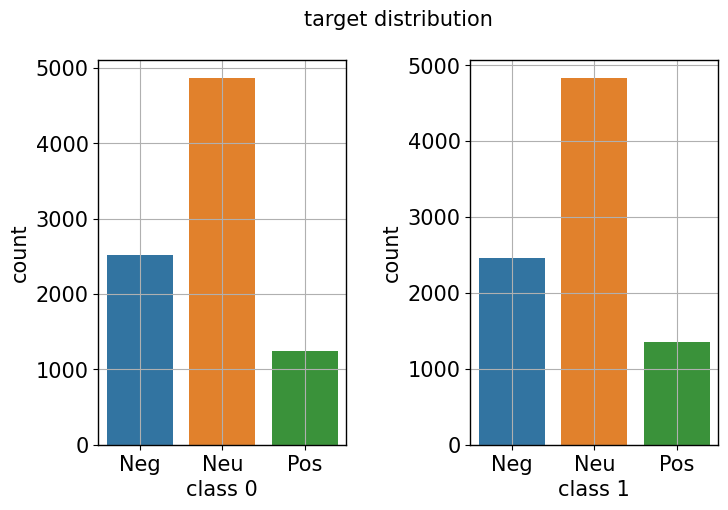

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# анализ распределения таргетов на твитах
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
plt.subplots_adjust(hspace=0.3, wspace=0.5)
fontsize=15

sns.countplot(data=extracted_train, x='0class', ax=axes[0])
axes[0].set_xlabel('class 0', fontsize=fontsize)
axes[0].set_ylabel('count', fontsize=fontsize)
axes[0].set_xticks([0, 1, 2], ['Neg', 'Neu', 'Pos'], fontsize=fontsize)
axes[0].grid(True)

sns.countplot(data=extracted_train, x='1class', ax=axes[1])
axes[1].set_xlabel('class 1', fontsize=fontsize)
axes[1].set_ylabel('count', fontsize=fontsize)
axes[1].set_xticks([0, 1, 2], ['Neg', 'Neu', 'Pos'], fontsize=fontsize)
axes[1].grid(True)

fig.suptitle('target distribution', fontsize=fontsize)

None

### Инициализируем модель (fine-tune) для решения нашей задачи классификации

In [9]:
fn_model_name = "DeepPavlov/distilrubert-base-cased-conversational"

class BERTmy(torch.nn.Module):
    def __init__(
        self, model_name: str, n_classes: int, 
        use_tok_type_ids: bool, p: float=0.05
    ) -> None:
        super(BERTmy, self).__init__()
        self.rubert = transformers.AutoModel.from_pretrained(
            model_name
        )
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(
            model_name, 
            do_lower_case=True,
            add_additional_tokens=True
        )
        self.use_tok_type_ids = use_tok_type_ids
        
        hidden_size_output = self.rubert.config.hidden_size
        self.pre_classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_size_output, hidden_size_output, bias=True),
            torch.nn.Dropout(p),
            torch.nn.ReLU()
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_size_output, hidden_size_output, bias=True),
            torch.nn.Dropout(p),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size_output, n_classes),
        )

    def forward(
        self, input_ids: torch.Tensor, attention_mask: torch.Tensor, 
        token_type_ids: torch.Tensor=None, output_attentions: bool=False,
        output_hidden_states: bool=False, return_dict: bool=True
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        
        input_dict = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'return_dict': True,
            'output_attentions': True,
            'output_hidden_states': True
        }
        if self.use_tok_type_ids and not token_type_ids is None:
            input_dict['token_type_ids'] = token_type_ids
        
        rubert_output = self.rubert(**input_dict)

        pooled = rubert_output['last_hidden_state']
        attentions = rubert_output['attentions']
        hid_states = rubert_output['hidden_states']

        output_pre_cls = self.pre_classifier(pooled[:, 0, :])
        logits = self.classifier(output_pre_cls)

        return {
            'logits': logits,
            'attentions': attentions,
            'hidden_states': hid_states
        }

In [10]:
def load_model_hf_cls(
    model_load: str, model_type: str, 
    load_model_weights: bool=False
) -> torch.nn.Module:

    assert model_type in ['distilbert', 'bert']

    tokenizer = AutoTokenizer.from_pretrained(
        model_load, do_lower_case=True,
        add_additional_tokens=True
    )

    if load_model_weights:
        model = AutoModel.from_pretrained(model_load)
        model_config = model.config
    else:
        model_config = AutoConfig.from_pretrained(model_load)

    model_cls = AutoModelForSequenceClassification.from_config(model_config)
    
    if load_model_weights:
        if model_type == 'distilbert':
            model_cls.distilbert = model
        elif model_type == 'bert':
            model_cls.bert = model
        del model

    return model_cls, tokenizer

In [11]:
distilbert_name = "DeepPavlov/distilrubert-base-cased-conversational"
bert_base_name = "DeepPavlov/rubert-base-cased"

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_cls = len(pd.unique(extracted_train['0class']))
load_tf = True

if load_tf:
    model_cls, tokenizer = load_model_hf_cls(
        distilbert_name, model_type='distilbert', 
        load_model_weights=False
    )
    seq_max_len = model_cls.config.max_position_embeddings
    hid_dim = model_cls.config.dim
    model_cls.dropout = torch.nn.Identity()
    model_cls.pre_classifier = torch.nn.Sequential(
        torch.nn.Linear(hid_dim, hid_dim, bias=False),
        torch.nn.Dropout(0.15),
        torch.nn.ReLU()
    )
    model_cls.classifier = torch.nn.Sequential(
        torch.nn.Linear(hid_dim, hid_dim, bias=False),
        torch.nn.Dropout(0.15),
        torch.nn.ReLU(),
        torch.nn.Linear(hid_dim, num_cls, bias=False),
    )
else:
    model_cls = BERTmy(model_name=distilbert_name, n_classes=num_cls, use_tok_type_ids=False)
    tokenizer = model_cls.tokenizer
    seq_max_len = model_cls.rubert.config.max_position_embeddings

clear_output()

In [12]:
train_batch_size = 24
val_batch_size = 24

class SentimentDataTransformer(Dataset):
    # инициализация датасета
    def __init__(
        self, texts: List[str], 
        labels: List[Tuple[int, ...]]=None,
        labels_amount: int=1
    ) -> None:

        self.texts = texts
        self.labels = labels

    # для получения размера датасета
    def __len__(self) -> int:
        return len(self.texts)

    # для получения элемента по индексу
    def __getitem__(
        self, index: int
    ) -> Tuple[Union[str, int]]:

        if self.labels is None:
            return self.texts[index]

        text = self.texts[index]
        labels = self.labels[index]
        
        target1, target2 = labels

        return text, target1, target2

In [13]:
class collate_fn_transformers():
    
    def __init__(
        self, tokenizer: AutoTokenizer, 
        use_labels:bool, use_tok_type_ids: bool
    ) -> None:
        
        self.tokenizer = tokenizer
        self.use_tok_type_ids = use_tok_type_ids
        self.use_labels = use_labels
        
    def __call__(self, batch):
        
        if not self.use_labels:

            texts = batch

            return self.tokenizer(
                texts, #truncation=True,
                padding=True, add_special_tokens=True,
                return_token_type_ids=self.use_tok_type_ids,
                return_tensors='pt'
            )
        
        texts, target1, target2 = zip(*batch)
        
        input_ids = self.tokenizer(
            texts, #truncation=True,
            padding=True, add_special_tokens=True,
            return_token_type_ids=self.use_tok_type_ids,
            return_tensors='pt'
        )
        target1 = torch.tensor(target1)
        target2 = torch.tensor(target2)
        
        return input_ids, target1, target2

### Инициализируем наши DataLoaders

In [14]:
train = SentimentDataTransformer(
    texts=extracted_train['text'].tolist(),
    labels=list(zip(extracted_train['0class'], extracted_train['1class']))
)

val = SentimentDataTransformer(
    texts=extracted_val['text'].tolist(),
    labels=list(zip(extracted_val['0class'], extracted_val['1class']))
)

collate_fn_bert = collate_fn_transformers(
    tokenizer=tokenizer, use_tok_type_ids=False, 
    use_labels=True
)

train_loader = DataLoader(
    train, batch_size=train_batch_size,
    shuffle=True, collate_fn=collate_fn_bert
)
val_loader = DataLoader(
    val, batch_size=val_batch_size,
    shuffle=False, collate_fn=collate_fn_bert
)
loaders = {
    'train': train_loader,
    'val': val_loader
}

### Дообучение модели

In [15]:
def train_model(
    epochs: int, model: torch.nn.Module, loaders: Dict[str, DataLoader], 
    optimizer: torch.optim, scheduler: torch.optim.lr_scheduler, 
    weights_vector: torch.tensor=None, device: str='cpu'
) -> None:
    # cross entropy loss
    model = model.to(device)
    if weights_vector is None:
        weights_vector = torch.ones(size=(num_cls,), device=device)
    loss_function1 = torch.nn.CrossEntropyLoss(reduction='mean', weight=weights_vector)
    loss_function2 = torch.nn.CrossEntropyLoss(reduction='mean', weight=weights_vector)
    
    # извлечение DataLoaders
    if len(loaders) > 1:
        train_loader = loaders['train']
        val_loader = loaders['val']
        steps_per_epoch = [('train', train_loader), ('val', val_loader)]
    else:
        train_loader = loaders['train']
        steps_per_epoch = [('train', train_loader)]

    # обучение по эпохам
    for epoch in range(epochs):
        for mode, loader in steps_per_epoch:
            # сохранение статистик
            train_loss = 0
            n_correct = 0
            processed_data = 0
            
            # train/val 
            if mode == 'train':
                model.train()
                requires_grad_mode = True
            else:
                model.eval()
                requires_grad_mode = False
            
            # проход по батчам
            for inputs, trg1, trg2 in tqdm(loader):
                # обнуляем градиенты
                optimizer.zero_grad()

                # извлечение входных данных для модели
                for key, value in inputs.items():
                    inputs[key] = value.to(device)
                trg1, trg2 = trg1.to(device), trg2.to(device)
                inputs['return_dict'] = True
                
                # устанавливаем необходимость вычислять/не_вычислять градиенты
                with torch.set_grad_enabled(requires_grad_mode):
                    outputs = model(**inputs)
                    preds = torch.argmax(outputs['logits'], dim=1)

                    # настраиваем модели на конкретный target
                    if all(trg1 == trg2):
                        loss1 = loss_function1(outputs['logits'], trg1)
                        train_loss += loss1.item()
                        n_correct += torch.sum(preds == trg1).cpu().detach().numpy()
                        if mode == 'train':
                            # вычисляем градиенты и обновляем веса
                            loss1.backward()
                            optimizer.step()
                    # если у твита более чем 1 метка, то настраиваем на обе
                    else:
                        loss1 = loss_function1(outputs['logits'], trg1) * 0.5
                        loss2 = loss_function2(outputs['logits'], trg2) * 0.5
                        loss_all = loss1 + loss2
                        train_loss += loss_all.item()

                        mask_singular = trg1 == trg2
                        mask_multiple = trg1 != trg2
                        singular = preds[mask_singular]
                        n_correct += torch.sum(
                            singular == trg1[mask_singular]
                        ).cpu().detach().numpy()
                        multiple = preds[mask_multiple]
                        n_correct += torch.sum(
                            (multiple == trg1[mask_multiple]) | (multiple == trg2[mask_multiple])
                        ).cpu().detach().numpy()
                        if mode == 'train':
                            # вычисляем градиенты и обновляем веса
                            loss_all.backward()
                            optimizer.step()

                    processed_data += len(preds)

            # вычисляем ошибку и точность прогноза на эпохе
            loader_loss = train_loss / processed_data
            loader_acc = n_correct / processed_data
            print(f'{epoch + 1} epoch with {mode} mode has: {loader_loss} loss, {loader_acc} acc')
        
        # делаем шаг для sheduler оптимайзера
        scheduler.step()

In [ ]:
# weigths for classes
weights_vector = torch.zeros(size=(num_cls,), device=device)
unique_labels, counts = np.unique(
    extracted_train['0class'], return_counts=True
)
sm_count = np.sum(counts)
for label, count in zip(unique_labels, counts):
    weights_vector[label] = 1 - count/sm_count

# train model
epochs = 1
optimizer = torch.optim.Adam([
    {'params': model_cls.pre_classifier.parameters(), 'lr': 7e-4},
    {'params': model_cls.classifier.parameters(), 'lr': 7e-4}
], lr=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
train_model(epochs, model_cls, loaders, optimizer, scheduler, weights_vector, device)

In [16]:
model_name = 'distilbert_cls.pth'

mode_process = input('Load weights? (y/n)')
if mode_process == 'n':
    torch.save(model_cls.state_dict(), model_name)
elif mode_process == 'y':
    model_cls.load_state_dict(
        torch.load('/kaggle/input/distilbert-teltecoms/distilbert_cls_telecom_2016.pth')\
    )
    print('all is matched!')
else:
    assert mode_process in ['n', 'y']
model_cls.eval()
None

Load weights? (y/n) y


all is matched!


### Вычисление итоговых показателей

In [17]:
def pass_data_transformers(
    model: torch.nn.Module, loader: DataLoader,
    loader_labels: bool=False, return_embs: bool=False,
    device: str='cpu', verbose: bool=False
) -> Tuple[np.array, Optional[np.array], Optional[np.array]]:
    """
    pass data from loader through bert model
    """
    model.eval()
    model = model.to(device)

    if verbose:
        pbar = tqdm(len(loader), leave=True, position=0)
    
    with torch.no_grad():

        all_probs = list()
        if loader_labels:
            all_labels1 = list()
            all_labels2 = list()
        if return_embs:
            all_embs = list()
        for idx, inputs in enumerate(loader):

            if loader_labels:
                ids, trg1, trg2 = inputs
            else:
                ids = inputs
            ids = ids.to(device)
            ids['return_dict'] = True
            outputs = model(**ids)
            logits = outputs['logits']
            if return_embs:
                embs = outputs['hidden_states'][-1][:, 0, :]
                all_embs.append(embs.cpu().detach().numpy())

            probs = torch.nn.functional.softmax(
                logits, dim=1
            ).cpu().detach().numpy()
            all_probs.append(probs)
            if loader_labels:
                all_labels1.append(trg1.cpu().detach().numpy())
                all_labels2.append(trg2.cpu().detach().numpy())

            if verbose:
                pbar.update(1)
                pbar.set_description(f'processed: {idx + 1}')

        all_probs = np.vstack(all_probs)
        if loader_labels:
            all_labels1 = np.hstack(all_labels1)
            all_labels2 = np.hstack(all_labels2)
        if return_embs:
            all_embs = np.vstack(all_embs)

    return_data = [all_probs]
    if loader_labels:
        return_data.append(all_labels1)
        return_data.append(all_labels2)
    if return_embs:
        return_data.append(all_embs)

    if len(return_data) > 1:
        return tuple(return_data)
    else:
        return return_data[0]

In [18]:
def calculate_accuracy(
    model: torch.nn.Module, loader: DataLoader,
    device: str='cpu', verbose: bool=True
) -> float:
    model.eval()
    model = model.to(device)
    
    # проход по батчам
    probs, trg1, trg2 = pass_data_transformers(
        model=model, loader=loader, device=device,
        loader_labels=True, verbose=verbose
    )
    preds = np.argmax(probs, axis=1)
    mask_singular = trg1 == trg2
    mask_multiple = trg1 != trg2
    singular = preds[mask_singular]
    n_correct = np.sum(singular == trg1[mask_singular])
    multiple = preds[mask_multiple]
    if len(multiple) > 0:
        n_correct += np.sum(
            
            (multiple == trg1[mask_multiple]) | (multiple == trg2[mask_multiple])
        )
    loader_acc = n_correct / len(preds)

    return loader_acc

def calculate_f1_class(
    model: torch.nn.Module, loader: DataLoader,
    class_num: int, device: str='cpu', verbose: bool=True
) -> float:
    model.eval()
    model = model.to(device)
    all_preds = list()
    groud_truth = list()

    # проход по батчам
    probs, trg1, trg2 = pass_data_transformers(
        model=model, loader=loader, device=device,
        loader_labels=True, verbose=verbose
    )
    preds = np.argmax(probs, axis=1)

    mask_preds = preds == class_num
    preds[mask_preds] = 1
    preds[~mask_preds] = 0
    trg = np.zeros(len(preds))
    mask_trg = (trg1 == class_num) | (trg2 == class_num)
    trg[mask_trg] = 1
    trg[~mask_trg] = 0

    return f1_score(trg, preds)

In [19]:
test_acc = calculate_accuracy(model_cls, val_loader, device)
class_neg_f1 = calculate_f1_class(model_cls, val_loader, 0, device)
class_neu_f1 = calculate_f1_class(model_cls, val_loader, 1, device)
class_pos_f1 = calculate_f1_class(model_cls, val_loader, 2, device)

processed: 94: : 94it [00:02, 37.73it/s]
processed: 94: : 94it [00:01, 55.83it/s]
processed: 94: : 94it [00:01, 56.00it/s]
processed: 94: : 94it [00:01, 55.65it/s]


In [20]:
# общая accuracy и f1 по классам
test_acc, class_neg_f1, class_neu_f1, class_pos_f1

(0.7454383622607922,
 0.7858472998137804,
 0.7371134020618556,
 0.5098901098901099)

## Backdoor attacks on neural network(adversial examples)

### USE metric for similarity between original sentence and spoiled sentence

In [21]:
# Load pre-trained universal sentence encoder model
use_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [22]:
def use_score(
    original: List[str], adversial: List[str],
    use_bert_encoder: bool=False, bert_batch_size: int=24
) -> Tuple[np.array, float]:
    # using DAN from tensorflow
    if not use_bert_encoder:
        global use_encoder
        # get embs of texts
        orig_emb = use_encoder(original)
        adv_emb = use_encoder(adversial)
    # using BERT itself
    else:
        global model_cls
        model_cls.eval()
        model_cls = model_cls.to(device)
        # calculate use_score with BERT
        
        orig_data = SentimentDataTransformer(texts=original)
        adv_data = SentimentDataTransformer(texts=adversial)
        collate_fn = collate_fn_transformers(
            tokenizer=tokenizer, use_tok_type_ids=False, 
            use_labels=False
        )
        orig_loader = DataLoader(
            orig_data, batch_size=bert_batch_size,
            shuffle=False, collate_fn=collate_fn
        )
        adv_loader = DataLoader(
            adv_data, batch_size=bert_batch_size,
            shuffle=False, collate_fn=collate_fn
        )

        orig_emb = pass_data_transformers(
            model=model_cls, loader=orig_loader, device=device,
            loader_labels=False, verbose=verbose, return_embs=True
        )[-1]
        adv_emb = pass_data_transformers(
            model=model_cls, loader=adv_loader, device=device,
            loader_labels=False, verbose=verbose, return_embs=True
        )[-1]

    # calculate use_score
    orig_lens = np.sum(orig_emb ** 2, axis=1)
    adv_lens = np.sum(adv_emb ** 2, axis=1)
    cosine_dist = np.sum(orig_emb * adv_emb, axis=1)
    use_scores = cosine_dist / (orig_lens * adv_lens)

    return use_scores, np.mean(use_scores)

### Prepare data for interpretation

In [23]:
min_length = 3
print(f'Кол-во текстов, длина которых больше {min_length}:"')
mask = extracted_val['text'].apply(lambda x: len(list(razdel.tokenize(x)))) > min_length
print(np.sum(mask))
print('Баланс классов:')
unique_labels, counts = np.unique(extracted_val.loc[mask, '0class'], return_counts=True)
print(unique_labels, counts / np.sum(mask))
adversial_examples = extracted_val[mask].reset_index(drop=True)

Кол-во текстов, длина которых больше 3:"
2233
Баланс классов:
[0 1 2] [0.46842812 0.45096283 0.08060905]


## Interpretation

In [24]:
from lime.lime_text import LimeTextExplainer
import shap
from captum.attr import (
    IntegratedGradients, LayerIntegratedGradients
)

In [25]:
def gather_back_tokens(tokens: List[str], tokens_type: str) -> str:
    """
    для превращения токенов в предложение
    tokens: список токенов
    tokens_type: natasha или razdel
    """
    assert tokens_type in ['razdel', 'natasha']

    sent = ''
    prev_end = None
    for token in tokens:

        if tokens_type == 'natasha':
            token_text = token['text']
            token_start, token_stop = token['start'], token['stop']
        else:
            token_text = token.text
            token_start, token_stop = token.start, token.stop
        
        if not prev_end is None:
            sent += (token_start - prev_end) * ' '

        sent += token_text
        prev_end = token_stop
 
    return sent

In [26]:
model_cls.eval()
model_cls = model_cls.to(device)

In [27]:
def predict_texts(texts: List[str], func_type: str, batch_size: int=30):
    """
    for Lime: return probability distribution of text
    """
    assert func_type in ['shap', 'lime']
    global tokenizer
    global model_cls
    global device

    if func_type == 'shap':
        texts = list(map(lambda x: re.sub(r'\.{3}', '[MASK]', x), texts))

    # get model outputs
    dataset = SentimentDataTransformer(texts=texts)
    loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False,
        collate_fn=collate_fn_transformers(
            tokenizer=tokenizer, use_labels=False,
            use_tok_type_ids=False
        )
    )
    probs = pass_data_transformers(
        model=model_cls, loader=loader, device=device,
        loader_labels=False, verbose=False, return_embs=False
    )
    
    return probs

### lime

In [28]:
def lime_importance(
    tokens: List[Tuple[str, int, int]], tokens_type: str, 
    num_features:int=300, num_samples:int=700
) -> List[str]:
    """
    measure contribution with lime weights
    """
    assert tokens_type in ['razdel', 'natasha']

    def RazdelSplit(text):
        return [raz_tok.text for raz_tok in list(razdel.tokenize(text))]

    def NatashaSplit(text):
        segmenter = Segmenter()
        text_doc = Doc(text.lower())
        text_doc.segment(segmenter)

        return [nat_tok['text'] for nat_tok in text_doc]

    # список для наиболее важных слов
    essential_words = list()
    text_to_explain = gather_back_tokens(tokens, tokens_type)

    if tokens_type == 'razdel':
        Spliter = RazdelSplit
    elif tokens_type == 'natasha':
        Spliter = NatashaSplit
    # создаем Explainer
    explainer = LimeTextExplainer(
        class_names=['Neg', 'Neu', 'Pos'],
        split_expression=Spliter
    )
    # "объясняем" текст
    explanation = explainer.explain_instance(
        text_to_explain, partial(predict_texts, func_type='lime'), 
        num_features=num_features, num_samples=num_samples
    )
    # создаем mapping из токена в его вес LogReg
    explanation_list = explanation.as_list()
    tok2weight = {token:weight for token, weight in explanation_list}
    # создаем список из токенов, их важности и позиции в тексте
    for token in tokens:
        if tokens_type == 'razdel':
            token_text = token.text.lower()
        else:
            token_text = token['text'].lower()

        essential_words.append((
            token, tok2weight[token_text]
        ))
    # создаем функцию сравнения важности
    sort_func = lambda x: np.abs(x[1])
    # сортируем токены по важности
    essential_words = sorted(essential_words, key=sort_func, reverse=True)
    # возвращаем только слова и их позиции в тексте
    essential_words = [word for word, _ in essential_words]

    return essential_words

### shap

In [29]:
def shap_importance(
    tokens: List[str], tokens_type: str, target: int
) -> List[str]:
    """
    measure contribution with shap values
    """
    assert tokens_type in ['razdel', 'natasha']

    def custom_tokenizer(
        text: str, return_offsets_mapping=True
    ) -> Dict[str, List[Union[str, Tuple[int, ...]]]]:
        """
        Custom tokenizers conform to a subset 
        of the transformers API
        """
        tokens = list(razdel.tokenize(text))
        
        words = list()
        offsets = list()
        for token in tokens:
            words.append(token.text)
            offsets.append((token.start, token.stop))

        return {
            'input_ids': words,
            'offset_mapping': offsets
        }

    # восстанавливаем текст из слов
    text_to_explain = gather_back_tokens(tokens,tokens_type)

    masker = shap.maskers.Text(custom_tokenizer)
    explainer = shap.Explainer(
        partial(predict_texts,func_type='shap'), masker, 
        output_names=['Neg', 'Neu', 'Pos']
    )
    # get shap values for the onliest text
    shap_values = explainer([text_to_explain])

    tokens_order = shap_values.data[0]
    base_values = shap_values.base_values
    contributions = shap_values.values[0].sum(axis=1)
    essential_words = list(zip(tokens, contributions))
    # создаем функцию сравнения важности
    sort_func = lambda x: x[1]
    # сортируем токены по важности
    essential_words = sorted(essential_words, key=sort_func, reverse=True)
    # возвращаем только слова и их позиции в тексте
    essential_words = [word for word, _ in essential_words]

    return essential_words

### alti

In [30]:
model_cls_wrapper = ModelWrapper(model_cls)

def alti_importance(
    tokens: List[Tuple[str, int, int]], tokens_type: str,
    measure_tokens_contributions: str
) -> List[str]:
    """
    measure contribution with alti decomposition
    """
    assert measure_tokens_contributions in ['cls', 'all_tokens']
    assert tokens_type in ['razdel', 'natasha']
    global model_cls_wrapper
    global tokenier
    global model_cls
    # восстанавливаем текст из слов
    text_to_explain = gather_back_tokens(tokens, tokens_type)

    text_tokens = tokenizer.tokenize(text_to_explain)
    text_input = tokenizer(
        text_to_explain, return_tensors="pt", 
        return_token_type_ids=False,
        return_offsets_mapping=True
    ).to(device)
    offset_mapping = text_input['offset_mapping'][0,1:-1,:].cpu().detach()
    text_input['return_dict'] = True
    del text_input['offset_mapping']

    # get words of text
    pos_words = [(word.start, word.stop) for word in tokens]

    # create mapping from token to word
    cur_index = 0
    token_pos_to_word = dict()
    for idx, (offset, token) in enumerate(zip(offset_mapping, text_tokens)):
        start, _ = offset
        while start >= pos_words[cur_index][1]:
            cur_index += 1
        token_pos_to_word[idx] = tokens[cur_index]

    # get contributions
    _, _, _, contributions_data = model_cls_wrapper(text_input)
    # get Yi from alti
    resultant_norm = torch.norm(
        torch.squeeze(contributions_data['resultants']),
        p=1, dim=-1
    )
    # get Cij from alti method
    # 'contributions' means Tij
    # alti requires scaling = min_sum
    normalized_contributions = normalize_contributions(
        contributions_data['contributions'], scaling='min_sum',
        resultant_norm=resultant_norm
    )
    # apply attention rollout and get seq of Ci
    contributions_mix = compute_joint_attention(normalized_contributions)
    # extract Ci after last self-attention layer
    joint_attention_layer = -1
    contributions_mix_last_hid = contributions_mix[joint_attention_layer]
    # define tokens to measure contributions
    if measure_tokens_contributions == 'cls':
        # contribution to token cls
        positions=np.array([0])
    else:
        # contribution to all tokens
        positions=np.arange(1, len(contributions_mix_last_hid) - 1)

    word_to_contribution = defaultdict(lambda: 0.0)
    for pos in positions:
        # get tokens contrubitons
        contributions_mix_cur = contributions_mix_last_hid[pos][1:-1]
        for idx, contribution in enumerate(contributions_mix_cur):
            word_to_contribution[token_pos_to_word[idx]] += contribution

    # функция для сортировки
    sort_func = lambda x: x[1]
    # сортируем токены по важности
    essential_words = sorted(
        [(word, cont) for word, cont in word_to_contribution.items()],
        key=sort_func, reverse=True
    )
    # возвращаем только слова и их позиции в тексте
    essential_words = [word for word, _ in essential_words]
    
    return essential_words

### Heuristic loss

In [31]:
def loss_importance(
    tokens: List[Tuple[str, int, int]], 
    target: Union[int, str], tokens_type: str
) -> List[str]:
    """
    measure contribution with loss changes
    """
    assert tokens_type in ['razdel', 'natasha']
    global device
    global tokenizer
    global model_cls
    # восстанавливаем текст из слов
    text_to_explain = gather_back_tokens(tokens, tokens_type)
    # список для наиболее важных слов
    essential_words = list()

    loss = torch.nn.CrossEntropyLoss()
    get_inputs = lambda x: tokenizer(
        x, padding=True, add_special_tokens=True,
        return_token_type_ids=False, return_tensors='pt'
    ).to(device)

    # get inputs and outputs from model
    inputs = get_inputs(text_to_explain)
    inputs['return_dict'] = True
    outputs = model_cls(**inputs)['logits']
    target_pt = torch.tensor([target], dtype=torch.long)

    # calculate loss for original text
    loss_score_integral = loss(
        outputs.cpu(), target_pt
    )
    # calculate loss for each token removed
    for idx, token in enumerate(tokens):
        # get text without one token
        tokens_copy = tokens.copy()
        tokens_copy.pop(idx)
        text_to_explain = gather_back_tokens(tokens_copy, tokens_type)
        # calculate loss without current word
        inputs = get_inputs(text_to_explain)
        inputs['return_dict'] = True
        with torch.no_grad():
            outputs = model_cls(**inputs)['logits']
        loss_score_part = loss(outputs.cpu(), target_pt)
        # add our score of change
        essential_words.append((
            token, (loss_score_part-loss_score_integral).cpu().detach().numpy()
        ))

    # создаем функцию сравнения важности
    sort_func = lambda x: x[1]
    # сортируем токены по важности
    essential_words = sorted(essential_words, key=sort_func, reverse=True)
    # возвращаем только слова и их позиции в тексте
    essential_words = [word for word, _ in essential_words]

    return essential_words

### attention

In [32]:
def attention_importance(
    tokens: List[Tuple[str, int, int]], tokens_type: str,
    measure_tokens_contributions: str
) -> List[str]:
    """
    measure contribution with transformers attention
    """
    assert measure_tokens_contributions in ['cls', 'all_tokens']
    assert tokens_type in ['razdel', 'natasha']
    global tokenier
    global model_cls
    # восстанавливаем текст из слов
    text_to_explain = gather_back_tokens(tokens, tokens_type)
        
    text_tokens = tokenizer.tokenize(text_to_explain)
    text_input = tokenizer(
        text_to_explain, return_tensors="pt", 
        return_token_type_ids=False,
        return_offsets_mapping=True
    ).to(device)
    offset_mapping = text_input['offset_mapping'][0,1:-1,:].cpu().detach()
    text_input['return_dict'] = True
    del text_input['offset_mapping']

    # get words of text
    pos_words = [(word.start, word.stop) for word in tokens]

    # create mapping from token to word
    cur_index = 0
    token_pos_to_word = dict()
    for idx, (offset, token) in enumerate(zip(offset_mapping, text_tokens)):
        start, _ = offset
        while start >= pos_words[cur_index][1]:
            cur_index += 1
        token_pos_to_word[idx] = tokens[cur_index]
    
    with torch.no_grad():
        contributions_mix_last_hid = compute_rollout(
            torch.cat(
                model_cls(**text_input)['attentions']
            ).mean(dim=1).cpu().detach().numpy()
        )[-1]

    if measure_tokens_contributions == 'cls':
        # contribution to token cls
        positions=np.array([0])
    else:
        # contribution to all tokens
        positions=np.arange(1, len(contributions_mix_last_hid) - 1)

    word_to_contribution = defaultdict(lambda: 0.0)
    for pos in positions:
        # get tokens contrubitons
        contributions_mix_cur = contributions_mix_last_hid[pos][1:-1]
        for idx, contribution in enumerate(contributions_mix_cur):
            word_to_contribution[token_pos_to_word[idx]] += contribution

    # функция для сортировки
    sort_func = lambda x: x[1]
    # сортируем токены по важности
    essential_words = sorted(
        [(word, cont) for word, cont in word_to_contribution.items()],
        key=sort_func, reverse=True
    )
    # возвращаем только слова и их позиции в тексте
    essential_words = [word for word, _ in essential_words]

    return essential_words

### gradients

In [33]:
head_mask = [None] * model_cls.config.num_hidden_layers
use_tok_type_ids=False

def gradient_importance(
    tokens: List[Tuple[str, int, int]], tokens_type: str,
    target: int, alpha_steps: int=20
) -> List[str]:
    """
    measure contribution with gradients
    """
    assert tokens_type in ['razdel', 'natasha']
    global device
    global tokenizer
    global model_cls
    model_cls.eval()
    model_cls = model_cls.to(device)

    def predict(
        input_ids: torch.tensor,
        attention_mask: torch.tensor
    ) -> torch.tensor:
        inputs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }
        logits = model_cls(**inputs)['logits']
        probs = torch.nn.functional.softmax(logits, dim=1)
        return probs
        

    # восстанавливаем текст из слов
    text_to_explain = gather_back_tokens(tokens, tokens_type)
    # интегрированные градиенты по слоям модели
    lig = LayerIntegratedGradients(predict, model_cls.distilbert.embeddings)
    
    text_tokens = tokenizer.tokenize(text_to_explain)
    text_input = tokenizer(
        text_to_explain, return_tensors="pt",
        padding=True, add_special_tokens=True,
        return_token_type_ids=use_tok_type_ids,
        return_offsets_mapping=True
    ).to(device)
    offset_mapping = text_input['offset_mapping'][0,1:-1,:].cpu().detach()
    text_input['return_dict'] = True
    del text_input['offset_mapping']
    
    # get words of text
    pos_words = [(word.start, word.stop) for word in tokens]

    # create mapping from token to word
    cur_index = 0
    token_pos_to_word = dict()
    for idx, (offset, token) in enumerate(zip(offset_mapping, text_tokens)):
        start, _ = offset
        while start >= pos_words[cur_index][1]:
            cur_index += 1
        token_pos_to_word[idx] = tokens[cur_index]

    # baseline от которого происходит расчет градиентов
    input_size = text_input["input_ids"].size()
    baseline = torch.zeros(input_size).type(torch.LongTensor).to(device)
    # расчет интегрированных (вдоль пути) градиентов
    attributes, deltasa = lig.attribute(
        inputs=text_input["input_ids"], baselines=baseline,
        additional_forward_args=(text_input["attention_mask"]),
        n_steps=alpha_steps, target=torch.tensor(target).to(device),
        return_convergence_delta=True,
    )
    # получаем вклад каждого отдельного токена
    attributes = attributes.sum(dim=-1).squeeze(0)[1:-1]
    toks_contributions = torch.abs(attributes / torch.norm(attributes))
    
    word_to_contribution = defaultdict(lambda: 0.0)
    for idx, contribution in enumerate(toks_contributions):
        word_to_contribution[token_pos_to_word[idx]] += contribution.item()
    
    # функция для сортировки
    sort_func = lambda x: x[1]
    # сортируем токены по важности
    essential_words = sorted(
        [(word, cont) for word, cont in word_to_contribution.items()],
        key=sort_func, reverse=True
    )
    # возвращаем только слова и их позиции в тексте
    essential_words = [word for word, _ in essential_words]

    return essential_words

### random important words

In [34]:
def extract_random_words(
    tokens: List[str]
) -> List[Tuple[str, int]]:
    """
    возвращает список слов в случайном порядке
    """
    permutation = np.random.permutation(len(tokens))

    return [tokens[idx] for idx in permutation]

In [35]:
# класс для извлечения слов текста по важности
class SpoilTexts:

    def __init__(self) -> None:

        self.texts = None
        self.words_to_rm_per_text = None


    @staticmethod
    def post_process_text(text: str) -> str:
        """
        для постобработки лишних символов и артефактов в тексте
        """
        adversial_text = text.strip()
        adversial_text = re.sub(r'\s+', ' ', adversial_text.strip())
        return adversial_text


    def extract_most_valuable_words(
        self, texts: List[str], targets: List[Union[str, int]], 
        method: str, return_words: bool=False, verbose: bool=False
    ) -> None:
        """
        с помощью заданного метода извлекаются
        наиболее важные слова в тексте для прогноза модели
        """
        assert method in ['shap', 'lime', 'loss', 'alti',
                          'random', 'attention', 'gradient']
        # тексты для дальнейшего использования
        self.texts = texts
        # отслеживание прогресса
        if verbose:
            pbar = tqdm(len(self.texts), leave=True, position=0)

        # хранение для каждого текста список слов по важности
        self.words_to_rm_per_text = list()
        for idx, (text, target) in enumerate(zip(texts, targets)):
            # токенизация текста на токены
            tokens = list(razdel.tokenize(text))
            # если попался текст из одного токена
            if len(tokens) == 1:
                self.words_to_rm_per_text.append(list())
                continue
            # токенизация с помощью razdel
            tokens_type = 'razdel'

            if method == 'shap':
                words_to_del_order = shap_importance(tokens, tokens_type, target)
            elif method == 'lime':
                words_to_del_order = lime_importance(tokens, tokens_type)
            elif method == 'alti':
                words_to_del_order = alti_importance(tokens, tokens_type, 'cls')
            elif method == 'loss':
                words_to_del_order = loss_importance(tokens, target, tokens_type)
            elif method == 'random':
                words_to_del_order = extract_random_words(tokens)
            elif method == 'attention':
                words_to_del_order = attention_importance(tokens, tokens_type, 'cls')
            elif method == 'gradient':
                words_to_del_order = gradient_importance(tokens, tokens_type, target)

            # токены razdel отсортированные по важности
            words_to_del_order = [
                (constr.text, constr.start, constr.stop) 
                for constr in words_to_del_order
            ]
            self.words_to_rm_per_text.append(words_to_del_order)
            # обновляем прогресс
            if verbose:
                pbar.set_description(f'processed: {idx + 1}')
                pbar.update(1)

        if return_words:
            return self.words_to_rm_per_text


    def generate_adv_texts(
        self, words_to_del_count: int,
        method_to_gen: str, verbose: bool=False
    ) -> List[str]:
        """
        для генерации испорченныx текстов
        за счет удаления наиболее важных токенов
        """
        assert self.texts is not None
        assert self.words_to_rm_per_text is not None
        assert len(self.texts) == len(self.words_to_rm_per_text)
        assert words_to_del_count > 0
        assert method_to_gen in ['once', 'iteration'] 
        # для отслеживания прогресса
        if verbose:
            pbar = tqdm(len(self.texts), leave=False, position=0)
        # для хранения испорченных текстов
        spoiled_texts = list()
        for idx, (text, words_to_del) in enumerate(
            zip(self.texts, self.words_to_rm_per_text)
        ):
            # выделяются токены на удаление
            # в случае если удалить нужно больше чем есть
            # обрезается последнее, самое неважное слов
            if words_to_del_count >= len(words_to_del):
                words_rm_count = len(words_to_del) - 1
            else:
                words_rm_count = words_to_del_count
            # сохраняем только первые важные слова
            # и сортируем по встречаемости их
            words_to_del = sorted(
                words_to_del[:words_rm_count],
                key=lambda x: x[1], reverse=False
            )

            # перевод текста в список символов
            text_symbols = list(text)
            # сдвиг при удалении
            shift = 0
            adversial_iteration = list()
            for jdx, (_, start, stop) in enumerate(words_to_del):

                text_symbols[start-shift:stop-shift] = ''
                shift += (stop-start)
                # если нужно сохранить только финальную версию
                if method_to_gen == 'once' and jdx == (words_rm_count - 1):
                    adversial_text = self.post_process_text(''.join(text_symbols))
                    adversial_iteration.append(adversial_text)
                # если нужно хранить все промежуточные результаты
                elif method_to_gen == 'iteration':
                    adversial_text = self.post_process_text(''.join(text_symbols))
                    adversial_iteration.append(adversial_text)

            # ничего не было удалено
            if len(adversial_iteration) == 0:
                adversial_iteration.append(None)

            # возвращение только финальной версии
            if method_to_gen == 'once':   
                spoiled_texts.append(adversial_iteration[0])
            # возвращение всхе промежуточных версий
            elif method_to_gen == 'iteration':
                for _ in range(len(adversial_iteration), words_to_del_count):
                    adversial_iteration.append(None)
                spoiled_texts.append(tuple(adversial_iteration))
            # шаг прогресса
            if verbose:
                pbar.set_description(f'processed: {idx + 1}')
                pbar.update(1)
        
        return spoiled_texts

### extract most important words

In [ ]:
texts = adversial_examples['text'].apply(lambda x: x.lower()).tolist()
targets = adversial_examples['0class'].tolist()
method = 'shap'
words_to_del_count = 2
add_type = 'iteration'

spoil_wrapper = SpoilTexts()
words_to_rm_per_text = spoil_wrapper.extract_most_valuable_words(
    texts=texts, targets=targets, verbose=True, method=method, return_words=True
)

In [36]:
adversial_iterationabs_len = len(spoiled_texts[0])
spoil_type_to_texts = dict()
cols_names = list()
for count in range(words_to_del_count):
    spoil_type_to_texts[f'{method}_{count+1}_del'] = list()
    cols_names.append(f'{method}_{count+1}_del')

for spoiled_tuple in spoiled_texts:
    for count in range(words_to_del_count):
        spoil_type_to_texts[f'{method}_{count+1}_del'].append(spoiled_tuple[count])
        
frame = pd.DataFrame(spoil_type_to_texts)
adversial_examples.drop(columns=cols_names, inplace=True, errors='ignore')
adversial_examples = pd.concat([adversial_examples, frame], axis=1, join='inner')

In [40]:
adversial_examples.to_csv('spoiled_text_all_methods_banks_2016.csv')

## Получение результатов

In [ ]:
adversial_examples = pd.read_csv('/kaggle/input/distilbert-teltecoms/spoiled_text_all_methods_telecoms_2016.csv')

In [ ]:
asr_scores = dict()
bert_use = dict()
dan_use = dict()
batch_size = 24
collate_fn_bert = collate_fn_transformers(
    tokenizer=tokenizer, use_tok_type_ids=False, 
    use_labels=True
)
original = adversial_examples['text'].tolist()
original_data = SentimentDataTransformer(texts=original)
original_loader = DataLoader(
    original_data, bucth_size=batch_size,
    shuffle=False, collate_fn=collate_fn_bert
)
orig_probs = pass_data_transformers(
    model=model_cls, loader=original_loader,
    loader_labels=False, device=device, 
    return_embs=False, verbose=True
)
orig_preds = np.argmax(orig_probs, axis=1)

for importance_method in ['loss', 'alti', 'shap', 'lime', 'random', 'attention', 'gradient']:
    for words_to_del in range(1, 3):
        col_name = f'{importance_method}_{words_to_del}_del'

        adversial = adversial_examples[col_name].tolist()
        adversial_data = SentimentDataTransformer(texts=adversial)
        adversial_loader = DataLoader(
            adversial_data, bucth_size=batch_size,
            shuffle=False, collate_fn=collate_fn_bert
        )
        adv_probs = pass_data_transformers(
            model=model_cls, loader=adversial_loader,
            loader_labels=False, device=device, 
            return_embs=False, verbose=True
        )
        adv_preds = np.argmax(adv_probs, axis=1)

        bert_use[col_name] = np.round(
            use_score(original, adversial, True)[1], 3
        )
        dan_use[col_name] = np.round(
            use_score(original, adversial)[1], 3
        )
        asr_scores[col_name] = np.round(
            np.sum(adv_preds != orig_preds) / len(orig_preds), 3
        )

clear_output()

## Вывод результатов

In [121]:
def generate_dataframe(
    dataset_name: str, dan_use: Dict[str, float], 
    bert_use: Dict[str, float], asr_scores: Dict[str, float]
):
    scores = [dan_use, bert_use, asr_scores]
    names = ['dan_use', 'bert_use', 'asr_score']

    dataframe_dct = {
        'dataset': list(),
        'method': list(),
        'asr_score': list(),
        'dan_use': list(),
        'bert_use': list()
    }

    for method in asr_scores.keys():
        dataframe_dct['method'].append(method)
    for _ in range(len(list(asr_scores.keys()))):
        dataframe_dct['dataset'].append(dataset_name)
    for name, score in zip(names, scores):
        for _, value in score.items():
            dataframe_dct[name].append(value)

    dataframe = pd.DataFrame(dataframe_dct)
    
    return dataframe

In [24]:
dataframe_banks = pd.read_csv('/kaggle/input/distilbert-banks/banks_results.csv', index_col=0)
dataframe_telecoms = pd.read_csv('/kaggle/input/distilbert-teltecoms/telecoms_results.csv', index_col=0)

In [25]:
dataframe_united = pd.concat([dataframe_banks, dataframe_telecoms], axis=0)
dataframe_united_multi = dataframe_united.set_index(['dataset', 'method'])
dataframe_united_pivot = dataframe_united.pivot(
    index='method', columns='dataset', values=['asr_score', 'bert_use', 'dan_use']
)
dataframe_united_asr = dataframe_united[['method', 'dataset', 'asr_score']].pivot(
    index='method', columns='dataset', values='asr_score'
)
dataframe_united_dan_use = dataframe_united[['method', 'dataset', 'dan_use']].pivot(
    index='method', columns='dataset', values='dan_use'
)
dataframe_united_bert_use = dataframe_united[['method', 'dataset', 'bert_use']].pivot(
    index='method', columns='dataset', values='bert_use'
)

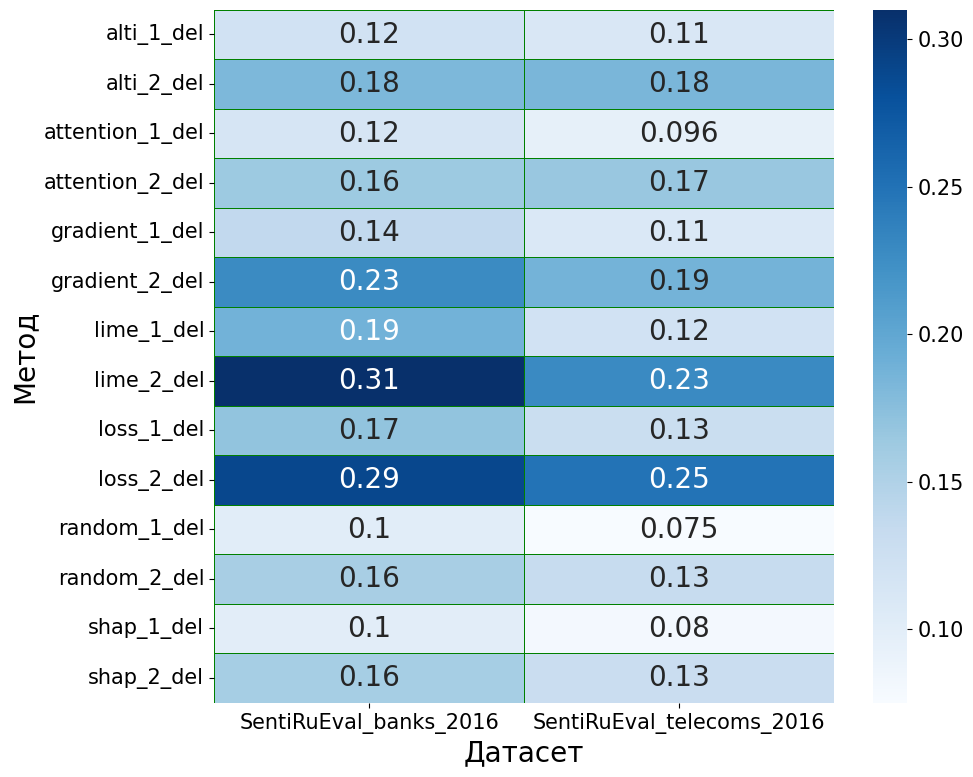

In [44]:
_, ax = plt.subplots(figsize=(10,9))
sns.heatmap(dataframe_united_asr, annot=True, linewidth=.5, cmap="Blues", linecolor='green', ax=ax)
ax.set_ylabel('Метод')
ax.set_xlabel('Датасет')
None